In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import numpy as np
import time
import jax.numpy as jnp
from jax import partial, jit, vmap, grad, random, lax
from jax.scipy.special import logsumexp

import context
from samplers.sgld import sgld_jaxloop, sgld_adam_time_budget
from samplers.sgldcv import sgld_jaxloop_CV
from samplers.sghmc import sghmc_scan, sghmc_time_budget
from samplers.mala import mala_sampler
from ksd import imq_KSD
from util import progress_bar_scan, wait_until_computed

# sgld - "logloss" method vs KSD method


### This notebook includes

- LR:
    - sgld: default vs SH-KSD method
    - sghmc: default vs SH-KSD method. Tune number of leapfrog steps L
    

Compare default and SH-KSD method using a time budget and training data only (80% of data)


Notes:
- For logistic regression and PMF, you get a good step using the default method.
- However you can't choose the batch_size (or parameters to do with variance reduction) in this way. You need to include the concept of a time budget



## Logistic regression

In [2]:

from examples.logistic_regression.logistic_regression_model import gen_data_and_log_post
from samplers.sgld import sgld, sgld_jaxloop, sgld_time_budget
from samplers.sgldcv import sgld_time_budget_CV


dim = 10
Ndata = 100000
key = random.PRNGKey(0) 
theta_true, X, y_data, val_and_grad_log_post = gen_data_and_log_post(key, dim, Ndata)

def _loglikelihood(theta, x_val, y_val):
        return -logsumexp(jnp.array([0., (1.-2.*y_val)*jnp.dot(theta, x_val)]))
    
_batch_loglik = jit(vmap(_loglikelihood, in_axes=(None, 0,0)))

@jit
def logloss(theta, X_test, y_test):
    return -jnp.mean(_batch_loglik(theta, X_test, y_test))

batch_logloss = jit(vmap(logloss, in_axes=(0, None, None)))

@partial(jit, static_argnums=(2,3,))
def get_logloss(key, dt, Nsamples, batch_size):
    x_0 = 0.2*random.normal(key, shape=theta_true.shape) + theta_true
    samples, grads = sgld_jaxloop(key, val_and_grad_log_post, X_train, y_train, Nsamples, dt, batch_size, x_0)
    logloss_array = batch_logloss(samples[:], X_test, y_test)
    return jnp.mean(logloss_array)



# testing and training data
num_train = int(Ndata*0.8)

X_train = X[:num_train]
X_test = X[num_train:]

y_train = y_data[:num_train]
y_test = y_data[num_train:]
print(X_train.shape, X_test.shape)



@jit
def fb_grads_LR_train(theta):
    return val_and_grad_log_post(theta, X_train, y_train)[1]

batch_fb_grads_LR_train = jit(vmap(fb_grads_LR_train, in_axes=(0,)))

generating data, with N=100000 and dim=10
(80000, 10) (20000, 10)


### first, try out the sampler

# sgld: grid search

In [11]:
key = random.PRNGKey(0)
Nsamples = 5000
batch_size = int(X.shape[0]*0.1)

log_dt_array = -jnp.arange(2, 7, 0.2) # linear grid on a log scale
dt_array = 10.**log_dt_array


In [12]:
key = random.PRNGKey(0)
Nsamples = 5000
batch_size = int(X.shape[0]*0.1)

log_dt_array = -jnp.arange(2, 7, 0.2) # linear grid on a log scale
dt_array = 10.**log_dt_array

starttime = time.time()
grid_logloss = [get_logloss(key, dt, Nsamples, batch_size) for dt in dt_array]

opt_log_dt = log_dt_array[np.argmin(grid_logloss)]
print(f"dt for the smallest logloss: 10^{opt_log_dt:.2f}")

print(f"Running time: {time.time()-starttime:.1f}sec")


dt for the smallest logloss: 10^-4.80
Running time: 94.5sec


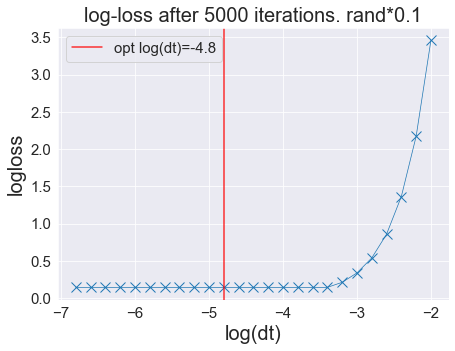

In [14]:
plt.rcParams.update({'font.size':15})
plt.figure(figsize=(7, 5))

plt.plot(log_dt_array, grid_logloss, marker="x", markersize=10, lw=0.7)
plt.xlabel("log(dt)", size=20)
plt.title(f"log-loss after {Nsamples} iterations. rand*0.1", size=20)
plt.ylabel("logloss", size=20)
plt.axvline(opt_log_dt, c='r', alpha=0.8, label=f"opt log(dt)={opt_log_dt:.1f}")
plt.legend()
plt.show()



# sgld-CV: evaluate default vs SH-KSD

## Run grid search

In [3]:
@partial(jit, static_argnums=(2,3,))
def get_logloss_sgld_CV(key, dt, Nsamples, batch_size):
    x_0 = 0.2*random.normal(key, shape=theta_true.shape) + theta_true
    samples, grads = sgld_jaxloop_CV(key, val_and_grad_log_post, X_train, y_train, 
                                     Nsamples, dt, batch_size, x_0, theta_true)
    logloss_array = batch_logloss(samples, X_test, y_test)
    return jnp.mean(logloss_array)

In [57]:
key = random.PRNGKey(0)
Nsamples = 5000
batch_size = int(X.shape[0]*0.1)

log_dt_array = -jnp.arange(2, 7, 0.2) # linear grid on a log scale
dt_array = 10.**log_dt_array

starttime = time.time()
grid_logloss_CV = [get_logloss_sgld_CV(key, dt, Nsamples, batch_size) for dt in dt_array]

opt_log_dt_CV = log_dt_array[np.argmin(grid_logloss_CV)]
print(f"sgld-CV: dt for the smallest logloss: 10^{opt_log_dt_CV:.2f}")

print(f"Running time: {time.time()-starttime:.1f}sec")


sgld-CV: dt for the smallest logloss: 10^-4.20
Running time: 73.8sec


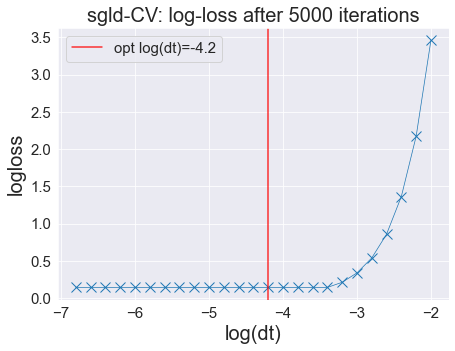

In [58]:
plt.rcParams.update({'font.size':15})
plt.figure(figsize=(7, 5))

plt.plot(log_dt_array, grid_logloss_CV, marker="x", markersize=10, lw=0.7)
plt.xlabel("log(dt)", size=20)
plt.title(f"sgld-CV: log-loss after {Nsamples} iterations", size=20)
plt.ylabel("logloss", size=20)
plt.axvline(opt_log_dt_CV, c='r', alpha=0.8, label=f"opt log(dt)={opt_log_dt_CV:.1f}")
plt.legend()
plt.show()



# SGHMC: tune leapfrog step



In [65]:


# @partial(jit, static_argnums=(2,3,4))
def get_logloss_sghmc(key, dt, Nsamples, batch_size, L):
    x_0 = 0.2*random.normal(key, shape=(theta_true.shape)) + theta_true
    alpha = 0.01
    samples, grads = sghmc_scan(key, Nsamples, dt, alpha, L, 
                                val_and_grad_log_post, batch_size, X_train, y_train, x_0)
    logloss_array = batch_logloss(samples, X_test, y_test)
    return jnp.mean(logloss_array)



# testing and training data
num_train = int(Ndata*0.8)

X_train = X[:num_train]
X_test = X[num_train:]

y_train = y_data[:num_train]
y_test = y_data[num_train:]
print(X_train.shape, X_test.shape)



(80000, 10) (20000, 10)


4.268994092941284



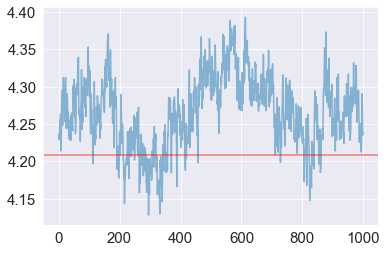

In [66]:

num_samples = 1000
batch_size = int(0.1*X_train.shape[0])
dt = 10**(-5.4)
alpha = 0.01
L = 10
key = random.PRNGKey(0)

# x_0 = random.normal(key, shape=(theta_true.shape)) # theta_true
x_0 = theta_true
starttime = time.time()
samples_hmc, grads_hmc = sghmc_scan(key, num_samples, dt, alpha, L, 
                                    val_and_grad_log_post, batch_size, X, y_data, x_0)
wait_until_computed(samples_hmc)
endtime = time.time()
print(endtime-starttime)

# samples_hmc[0][0].block_until_ready()
# print(imq_KSD(samples_hmc, grads_hmc))

plt.plot(samples_hmc[:,0], label="sg-hmc", alpha=0.5)
plt.axhline(theta_true[0], c='r', alpha=0.5)

In [67]:
imq_KSD(samples_hmc, grads_hmc)

DeviceArray(15.756978, dtype=float32)

In [68]:


num_samples = 1000
batch_size = int(0.1*X.shape[0])
dt = 1e-4
alpha = 0.01
L = 10

get_logloss_sghmc(key, dt, num_samples, batch_size, L)

DeviceArray(2.7413654, dtype=float32)

### grid search

In [6]:
jnp.arange(2, 7, 2)

DeviceArray([2, 4, 6], dtype=int32)

In [9]:
jnp.arange(1,100, 10.)

DeviceArray([ 1., 11., 21., 31., 41., 51., 61., 71., 81., 91.], dtype=float32)

In [70]:
key = random.PRNGKey(0)
Nsamples = 1000
batch_size = int(X_train.shape[0]*0.1)


log_dt_array = -jnp.arange(2, 7, 2)
L_array = jnp.arange(1,100, 10.)
dt_array = 10.**log_dt_array

dt_L_combinations = [(a,b) for a in dt_array for b in L_array]
print(len(dt_L_combinations))

30


In [71]:
starttime = time.time()
grid_logloss = [get_logloss_sghmc(key, dt, Nsamples, batch_size, L) for dt,L in dt_L_combinations]


opt_log_dt = dt_L_combinations[np.argmin(grid_logloss)]
print(f"dt for the smallest logloss: 10^{opt_log_dt}")

endtime = time.time()
print(f"Running time: {endtime-starttime:.2f}sec")


dt for the smallest logloss: 10^(1e-06, 11.0)
Running time: 434.65sec


In [74]:
# old

opt_log_dt = dt_L_combinations[np.argmin(grid_logloss)]
print(f"dt for the smallest logloss: 10^{opt_log_dt}")

dt for the smallest logloss: 10^(1e-06, 11.0)
